In [50]:
import random
import torch
from torch import nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from torchgeo.models import resnet50
from glob import glob
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from PIL import Image

from data.dataset import FSSDataset
from model.DCAMA import DCAMA

torch.manual_seed(42)
random.seed(42)

In [51]:
FSSDataset.initialize(img_size=256, datapath='D:/FYP/Code/DCAMA/datasets', use_original_imgsize=False)
n_shot = 5
dataloader_test = FSSDataset.build_dataloader('serp', 1, 0, 0, 'train', n_shot)

In [52]:
def get_pretrained_model(model_path: str = None):
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=10,
        classes=1,
    )
    model_resnet = resnet50('sentinel2', 'all', pretrained=True)
    del model_resnet.fc
    del model_resnet.avgpool
    model.encoder.load_state_dict(model_resnet.state_dict())
    model.segmentation_head[2].activation = nn.Sigmoid()
    model = model.float()
    
    if model_path:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
    
    return model

class BAM(nn.Module):
    def __init__(self, meta_model, base_model_path: str, meta_thresh: float = 0.5, base_thresh: float = 0.5) -> None:
        super().__init__()
        self.meta_model = meta_model.float()
        self.base_model = get_pretrained_model(base_model_path).float()
        self.meta_thresh = meta_thresh
        self.base_thresh = base_thresh
    
    def forward(self, batch):
        out_meta = self.meta_model.predict_mask_nshot(batch, nshot=n_shot)
        print(out_meta.min(), out_meta.float().mean(), out_meta.max())
        out_base = self.base_model(batch['query_img'])
        print(out_base.min(), out_base.float().mean(), out_base.max())
        out_base_thresh = out_base > self.base_thresh
        
        return torch.logical_and(out_meta, torch.logical_not(out_base_thresh)), out_meta, out_base_thresh
        # return (out_meta - self.meta_thresh) > (out_base - self.base_thresh), out_meta_thresh, out_base_thresh

In [53]:
model_1 = DCAMA('resnet50', True) 
params = model_1.state_dict()
state_dict = torch.load(r"D:\FYP\Code\DCAMA\best_model.pt", map_location='cpu')

for k1, k2 in zip(list(state_dict.keys()), params.keys()):
    state_dict[k2] = state_dict.pop(k1)

model_1.load_state_dict(state_dict)
   
model_2 = sorted(glob('D:/FYP/Code/Explore/models/agri_model_*.pt'))[-1]
model = BAM(model_1, model_2, 0.5, 0.9)

In [ ]:
with torch.no_grad():
    for batch in dataloader_test:
        image = batch['query_img']
        mask, _, _ =  model(batch)
        mask = mask.squeeze()
        img = image.squeeze().numpy()
        img = img[:3, :, :].transpose(1, 2, 0) / img.max() * 255

In [46]:
img.shape

(256, 256, 3)

In [47]:
img.min()

0.03653846153846154

tensor(0) tensor(0.) tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0., grad_fn=<MinBackward1>) tensor(0.5000, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<MaxBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


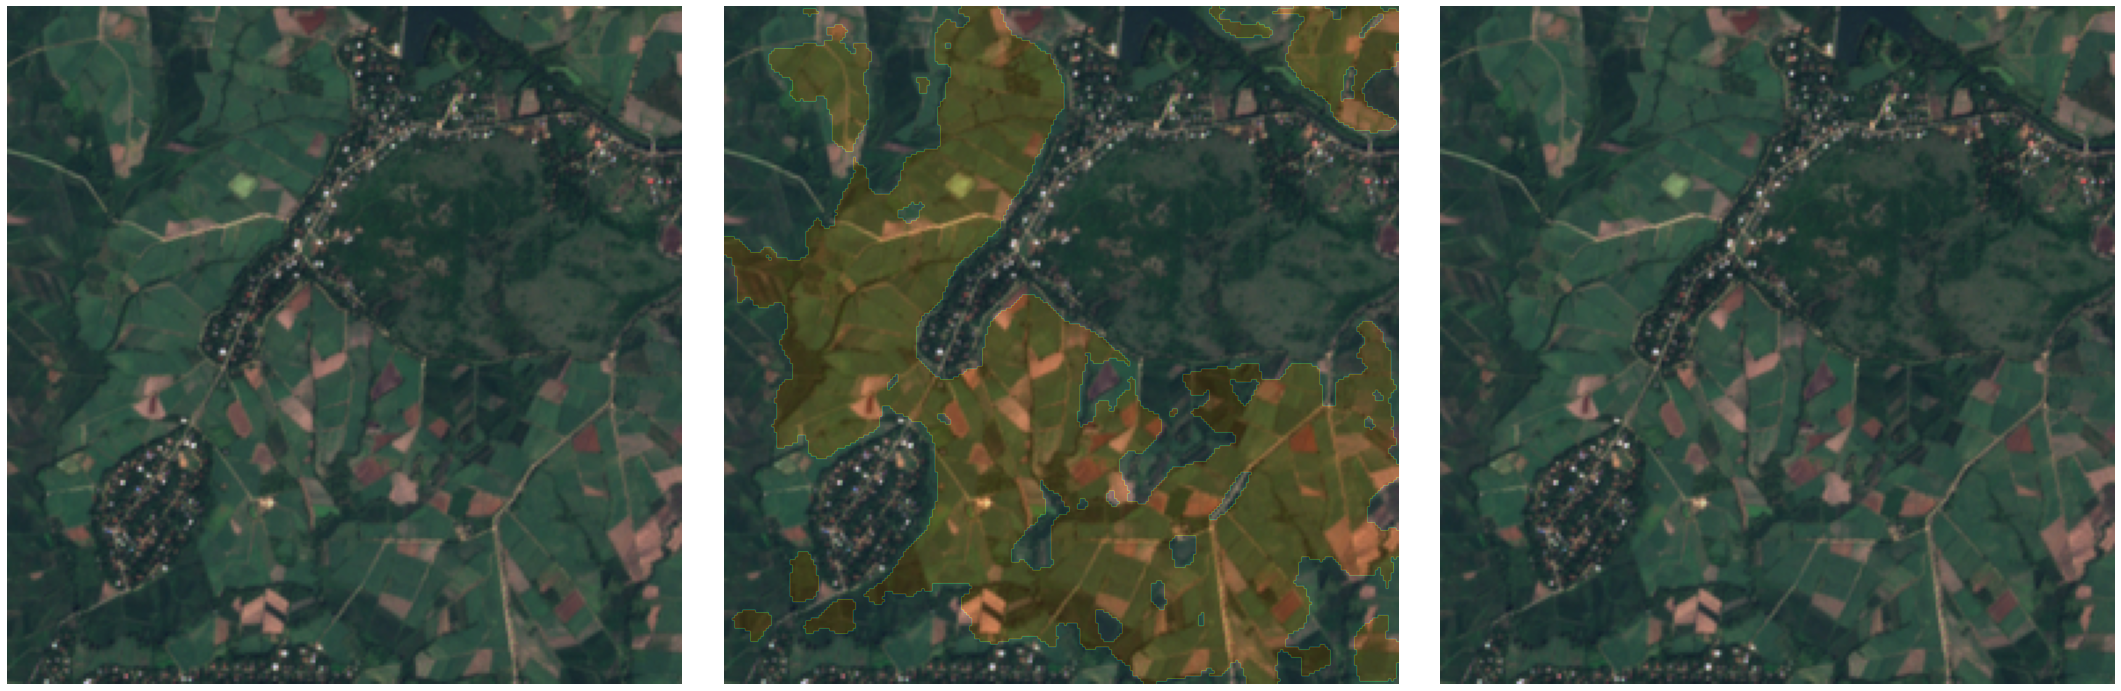

In [55]:
dl_iter = iter(dataloader_test)
idx = 1
batch = next(dl_iter)
for i in range(idx):
    batch = next(dl_iter)

img = np.load(os.path.join("D:/FYP/Code/DCAMA/datasets/Serp/0", batch['query_name'][0]))[:3].transpose(1, 2, 0) / 2000
out, meta, base = model(batch)
out, meta, base = out.squeeze(), meta.squeeze(), base.squeeze()


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
fig.tight_layout()
axes = axs.flatten()
plt.sca(axes[2])
# plt.figure(figsize=(10, 10))
plt.imshow(img, aspect='auto')
plt.imshow(out, cmap='jet', alpha=0.2, aspect='auto')
plt.axis('off')
plt.sca(axes[0])
# plt.figure(figsize=(10, 10))
plt.imshow(img, aspect='auto')
plt.imshow(meta, cmap='jet', alpha=0.2, aspect='auto')
plt.axis('off')
plt.sca(axes[1])
# plt.figure(figsize=(10, 10))
plt.imshow(img, aspect='auto')
plt.imshow(base, cmap='jet', alpha=0.2, aspect='auto')
plt.axis('off')
plt.show()

In [54]:
def jaccard_index(pred, target):
    return torch.logical_and(pred, target).sum() / torch.logical_or(pred, target).sum()

In [23]:
class CustomDataset(Dataset):
    def __init__(self, data_dir: str):
        super().__init__()
        self.img_list = glob(os.path.join(data_dir, '*.npy'))
        self.mask_list = glob(os.path.join(data_dir, '*.png'))
    
    def __len__(self):
        return len(self.mask_list)
    
    def __getitem__(self, index):
        img = np.load(self.img_list[index]).astype(float).transpose(1, 2, 0)
        img = TF.to_tensor(img)[:10, :, :]
        mask = Image.open(self.mask_list[index])
        mask = TF.to_tensor(mask) / 255
            
        return img.float(), mask.float()

In [24]:
dataset = CustomDataset('data/train')

In [25]:
ious = [[0] * 10 for _ in range(10)]
size = len(dataset)
train_size = int(size * 0.8)
_, val_set = torch.utils.data.random_split(dataset, [train_size, size - train_size])
val_loader = DataLoader(val_set, 4, False)

In [104]:
model = BAM(model_1, model_2, 0.1, 0.1)
for i in range(1, 11):
    for j in range(1, 11):
        model.base_thresh = 0.1 * i
        model.meta_thresh = 0.1 * j
        iou = 0
        with torch.no_grad():
            for img, mask in val_loader:
                out, meta, base = model(img)
                iou += jaccard_index(out, mask.int())
        ious[i - 1][j - 1] = iou / len(val_loader)

<AxesSubplot:>

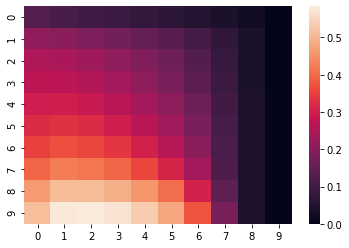

In [105]:
import seaborn as sns
sns.heatmap(ious)

In [26]:
iou_avg = 0
iou_meta_avg = 0
for seed in range(10):
    torch.manual_seed(seed)
    size = len(dataset)
    train_size = int(size * 0.8)
    _, val_set = torch.utils.data.random_split(dataset, [train_size, size - train_size])
    val_loader = DataLoader(val_set, 4, False)

    iou_ens = 0
    iou_met = 0
    with torch.no_grad():
        for img, mask in val_loader:
            out, meta, base = model(img)
            iou_ens += jaccard_index(out, mask).item()
            iou_met += jaccard_index(meta, mask).item()
    iou_ens /= len(val_loader)
    iou_met /= len(val_loader)
    iou_avg += iou_ens / 10
    iou_meta_avg += iou_met / 10
    print(f'Val IoU: {iou_ens}, {iou_met}')
print('IoU average', iou_avg, iou_meta_avg)

ZeroDivisionError: division by zero